# Long term simulation of join code usage

This notebook simulates a continuous data collection using N tasks, M agents and K different instances per agent. Each data point uses R concurrent agents. The simulation tests:

* The distribution of data collection over tasks.
* The correct usage of join codes without repeating busy instances.
* The average amount of free instances

In [1]:
import matplotlib.pyplot as plt
import numpy
import pandas
import seaborn

from copy import deepcopy

In [2]:
%run -i ../../common/priority_queue.py
%run -i ../task_management/task_manager.py

In [3]:
import logging
loggers = [logging.getLogger(name) for name in logging.root.manager.loggerDict]
for logger in loggers:
    logger.setLevel(logging.WARNING)

In [4]:
# Simulation parameters
N_TASKS = 10
M_AGENTS = 3
K_INSTANCES = 4
R_CONCURRENT_INSTANCES = 2

# Simulation data
TEST_TASKS = {
    f"task{task_id}": {
        "task_id": f"task{task_id}_id",
        "task_join_code": f"task{task_id}_join_code"
    } for task_id in range(N_TASKS)
}


TEST_AGENTS = {}
for agent_id in range(M_AGENTS):
    TEST_AGENTS[f"agent{agent_id}"] = [
        {
            "agent_instance_id": f"agent{agent_id}_instance{instance_id}_id",
            "agent_instance_name": f"agent1{agent_id}_instance{instance_id}",
        } for instance_id in range(K_INSTANCES)
    ]

    
TEST_TASKS_FILENAME = 'TEST_TASKS_FILENAME'
TEST_AGENTS_FILENAME = 'TEST_AGENTS_FILENAME'


class TaskManagerMock(TaskManager):

    @staticmethod
    def read_json_file(json_filepath):
        """Mock that returns constant value instead of content of `agent_info_filepath`."""
        if json_filepath == TEST_TASKS_FILENAME:
            return deepcopy(TEST_TASKS)
        elif json_filepath == TEST_AGENTS_FILENAME:
            return deepcopy(TEST_AGENTS)
        raise ValueError(f'Incorrect filepath for TaskManagerMock: {json_filepath}')


The simulation has the following steps:
  1. Requests all possible join codes to the task manager
  2. While is not done:
      1. Select a random code to be completed
      2. Ask for a new join code

In [5]:

class Simulation:
    def __init__(self, concurrent_instances):
        self.task_manager = TaskManagerMock(
            TEST_TASKS_FILENAME, TEST_AGENTS_FILENAME, agent_combination_size=concurrent_instances)
        self.generated_codes = []
        self.code_pairs_in_use = []
        self.completed_codes = []
        self.completed_task_agent_pairs = []
        self.instances_in_use = set()
        self.concurrent_instances = concurrent_instances
        self.codes_completed_before_next_batch = [0]

        self.all_instances = self._get_free_instances()

    def _get_free_instances(self):
        return set([
            agent_instance_info
            for agent_instances in self.task_manager.free_agent_instances.values()
            for agent_instance_info in agent_instances
        ])
        
    def _record_code_in_use(self, join_codes):
        # Check instance use
        for join_code in join_codes:
            assert join_code.agent_instance_id not in self.instances_in_use
            self.instances_in_use.add(join_code.agent_instance_id)
        
        # Store metrics
        self.code_pairs_in_use.append(join_codes)
        self.generated_codes.extend(join_codes)
    
    def _complete_codes(self, completed_codes):
        task_agents_pair = [completed_codes[0].task_name]
        for code in completed_codes:
            self.task_manager.complete_join_code(code.build_string())
            self.completed_codes.append(code)
            self.instances_in_use.remove(code.agent_instance_id)
            task_agents_pair.append(code.agent_name)
        self.completed_task_agent_pairs.append(task_agents_pair)
    
    def _check_correct_free_instances(self):
        free_instances = self._get_free_instances()
        if self.all_instances != self.instances_in_use.union(free_instances):
            print('Error! Task manager free instances + recorded instances in use is not equal to all instances')
            print('All instances', self.all_instances)
            print('Free instances according to simulation', self.all_instances.difference(self.instances_in_use))
            print('Free instances according to Task manager', self._get_free_instances())
            return False
        return True
    
    def start(self, steps=100):
        # Ask for all available codes
        while True:
            join_codes = self.task_manager.get_next_join_codes()
            if join_codes is None:
                break
            self._record_code_in_use(join_codes)
            free_agents = self.task_manager.get_available_agents()

        # Start code completion
        for step in range(steps):
            if len(self.code_pairs_in_use) > 0:
                # COMPLETE RANDOM CODE
                codes_to_complete = self.code_pairs_in_use.pop(
                    numpy.random.randint(len(self.code_pairs_in_use)))
                self._complete_codes(codes_to_complete)
                self.codes_completed_before_next_batch[-1] += 1
            
            if not self._check_correct_free_instances():
                break
                
            # GENERATE NEXT CODE
            join_codes = self.task_manager.get_next_join_codes()

            if join_codes is None:
                free_agents = self.task_manager.get_available_agents()
                if len(free_agents) > self.concurrent_instances:
                    print('No code generated, but enough free agents')
                    print('Free agents', free_agents)
                    print('Free instances', free_instances)
                    break
                continue
            self.codes_completed_before_next_batch.append(0)
            self._record_code_in_use(join_codes)
            if not self._check_correct_free_instances():
                break
    
    def end(self):
        """Complete all remaining codes"""
        while len(self.code_pairs_in_use) > 0:
            codes_to_complete = self.code_pairs_in_use.pop(numpy.random.randint(len(self.code_pairs_in_use)))
            self._complete_codes(codes_to_complete)

In [15]:
simulation = Simulation(R_CONCURRENT_INSTANCES)
simulation.start(200)
#simulation.end()

In [16]:
collected_data = pandas.DataFrame(data=[
    code.to_dict() for code in simulation.completed_codes
])

In [17]:
collected_data.sample(3)

,task_name,task_id,task_join_code,agent_name,agent_instance_id
365,task7,task7_id,task7_join_code,agent2,agent2_instance3_id
3,task7,task7_id,task7_join_code,agent2,agent2_instance1_id
313,task2,task2_id,task2_join_code,agent2,agent2_instance2_id


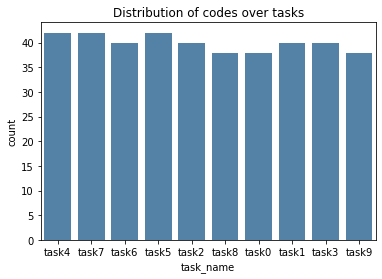

In [18]:
seaborn.countplot(data=collected_data, x='task_name', color='steelblue').set(title='Distribution of codes over tasks');

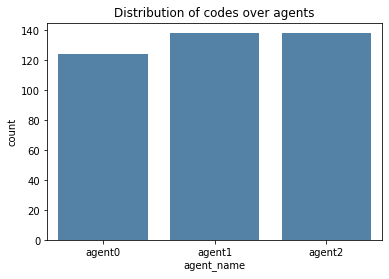

In [19]:
seaborn.countplot(data=collected_data, x='agent_name', color='steelblue').set(title='Distribution of codes over agents');

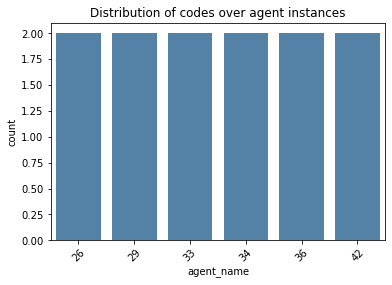

In [20]:
seaborn.countplot(
    data=collected_data.groupby('agent_instance_id').count(), x='agent_name',
    color='steelblue').set(title='Distribution of codes over agent instances')
plt.xticks(rotation=45);

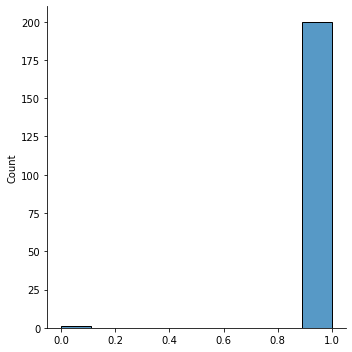

In [21]:
seaborn.displot(simulation.codes_completed_before_next_batch);

In [22]:
def concat_pair(row):
    if row.agent1 < row.agent2:
        return row.agent1 + '-' + row.agent2
    return row.agent2 + '-' + row.agent1

completed_task_agent_pairs = pandas.DataFrame(simulation.completed_task_agent_pairs, columns=['task_name', 'agent1', 'agent2'])
completed_task_agent_pairs['agent_pair'] = completed_task_agent_pairs.apply(concat_pair, axis=1)
completed_task_agent_pairs.sample(2)

,task_name,agent1,agent2,agent_pair
175,task2,agent1,agent2,agent1-agent2
96,task5,agent0,agent1,agent0-agent1


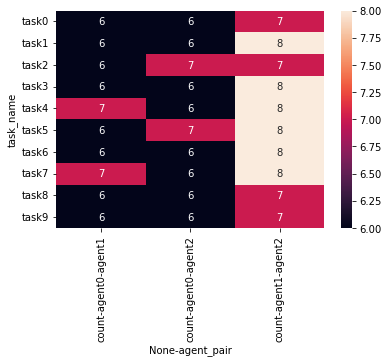

In [23]:
seaborn.heatmap(
    completed_task_agent_pairs[['task_name', 'agent_pair', 'agent1']]\
        .groupby(['task_name', 'agent_pair']).count()\
        .reset_index().rename(columns={'agent1': 'count'})\
        .pivot(index='task_name', columns='agent_pair'),
    annot=True
);